## Описание проекта. Телеком


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. 

Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг
Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:

- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. 

Доступны различные способы расчёта и возможность получить электронный чек.

In [41]:
import pandas as pd
# import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

from sqlalchemy import create_engine 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ( 
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold
)

from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.compose import ColumnTransformer
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    make_scorer,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)

# from catboost import CatBoostClassifier
# from catboost import CatBoostRegressor

# from lightgbm import LGBMClassifier

# from sklearn.ensemble import StackingClassifier

RANDOM_STATE = 270822

## Описание данных

Таблица contract
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка данных

In [42]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
}
 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string) 

In [43]:
contract = pd.read_sql_query('''
SELECT * FROM telecom.contract
''', con=engine) 

personal = pd.read_sql_query('''
SELECT * FROM telecom.personal
''', con=engine) 

internet = pd.read_sql_query('''
SELECT * FROM telecom.internet
''', con=engine) 

phone = pd.read_sql_query('''
SELECT * FROM telecom.phone
''', con=engine)

In [44]:
print(contract.info())
display(contract.head(10))

print(personal.info())
display(personal.head(10))

print(internet.info())
display(internet.head(10))

print(phone.info())
display(phone.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB
None


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


In [45]:
internet.columns = internet.iloc[0].values
internet = internet.iloc[1:].reset_index(drop=True)

phone.columns = phone.iloc[0].values
phone = phone.iloc[1:].reset_index(drop=True)


In [46]:
display(phone.head())
display(internet.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [47]:
contract['Target'] = contract['EndDate'].isna()

## Исследовательский анализ и предобработка данных

In [48]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,True
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,True
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,True
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN,True
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN,True
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN,True
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN,True
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN,True
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN,True
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN,True


In [49]:
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = contract['MonthlyCharges']
contract['EndDate'] = contract['EndDate'].fillna('2020-02-01')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [53]:
contract['Target'].value_counts()

Target
True     5174
False    1869
Name: count, dtype: int64

In [50]:
print(contract.info())
display(contract.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(2), object(4)
memory usage: 447.2+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,True
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,True
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,False
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,True
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,False
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,False
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,True
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,True
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,False
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,True


In [73]:
df = contract.merge(personal, on='customerID').merge(internet, how='left', on='customerID').merge(phone, how='left', on='customerID')

In [74]:
df = df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})

In [75]:
display(df.head())
print(df.info())
display(df.describe())

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,True,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,True,Male,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,False,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,True,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,False,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   bool          
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

,BeginDate,EndDate,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043,7043,7043.000000,7043.000000,7043.000000
mean,2019-03-20 03:51:02.274599168,2020-01-11 12:56:19.696152064,64.761692,2279.798992,0.162147
min,2018-04-17 00:00:00,2019-10-01 00:00:00,18.250000,18.800000,0.000000
25%,2019-01-18 12:00:00,2020-01-01 00:00:00,35.500000,398.550000,0.000000
50%,2019-03-22 00:00:00,2020-02-01 00:00:00,70.350000,1394.550000,0.000000
75%,2019-05-21 00:00:00,2020-02-01 00:00:00,89.850000,3786.600000,0.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,8684.800000,1.000000
std,NaN,NaN,30.090047,2266.730170,0.368612


In [57]:
categorical = []
continious = []

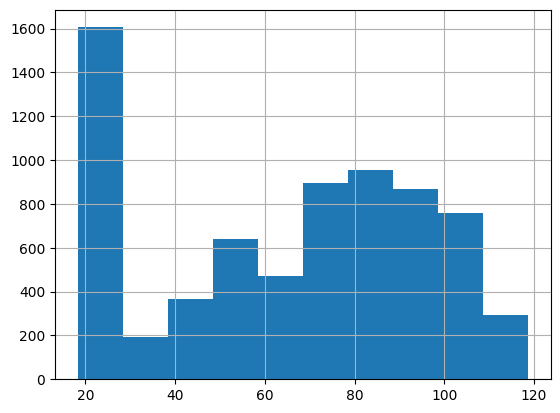

In [36]:
plt.hist(contract['MonthlyCharges'])
plt.grid(True)

In [ ]:
categorical = []
continious = []

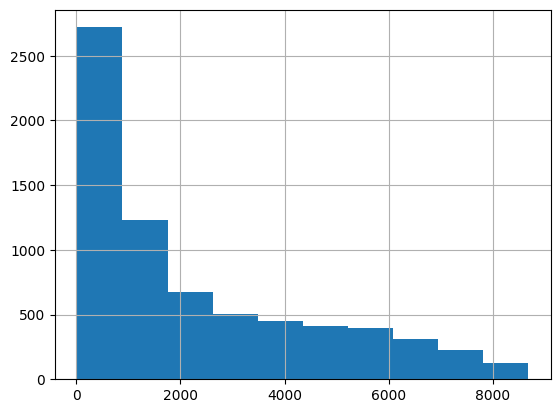

In [37]:
plt.hist(contract['TotalCharges'])
plt.grid(True)

In [39]:
print(contract.info())
display(contract.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35


## Обучение модели

## Тестирование модели и демонстрация её работы